References : 
https://github.com/devakar/deep-learning-books/blob/master/Hands%20on%20Machine%20Learning%20with%20Scikit%20Learn%20and%20TensorFlow.pdf

In [0]:
from google.colab import drive

In [0]:
drive.mount('/content/gdrive/')

In [0]:
import os
import numpy as np
import tensorflow as tf
import pickle
import librosa
import random
import matplotlib.pyplot as plt

# Loading train and test data

In [0]:
def getData(pickle_path):
  pickle_data = []
  
  if os.path.exists(pickle_path):
    pickle_data = pickle.load(open(pickle_path, 'rb'))
    print('Pickle already exists! Extracting the data from the pickle')
    
  else:
    print('Pickle doesnt exist! Loading the data from input files')
    
  return pickle_data

In [5]:
directory_path = '/content/gdrive/My Drive/Colab Notebooks/'
train_pickle = directory_path + 'hw4_tr7.pkl'

train_data = getData(train_pickle)

Pickle already exists! Extracting the data from the pickle


In [6]:
directory_path = '/content/gdrive/My Drive/Colab Notebooks/'
test_pickle = directory_path + 'hw4_te7.pkl'

test_data = getData(test_pickle)

Pickle already exists! Extracting the data from the pickle


# Training

## Creating Encoder and Decoder model

Enoder will output the mean and variance vectors

In [0]:
def Encoder(x):
  # Input Layer
  input_layer = tf.reshape(x, [-1, 28, 28, 1])
  
  # Convolutional Layer #1
  conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=16,
      kernel_size=[4,4],
      padding="same",
      activation=tf.nn.relu,
      kernel_initializer=tf.contrib.layers.xavier_initializer())

  # Pooling Layer #1
  pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[4,4], strides=4)

  # Convolutional Layer #2 and Pooling Layer #2
  conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=32,
      kernel_size=[2,2],
      padding="same",
      activation=tf.nn.relu,
      kernel_initializer=tf.contrib.layers.xavier_initializer())

  pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[4,4], strides=4)  
    
  # Flatten layer
  pool2_flat = tf.layers.flatten(pool2)
  # Dense Layer
  logits = tf.layers.dense(inputs=pool2_flat, units=784, activation=tf.nn.relu)
  
  #Since there are 6 units, 3 are mean
  output = tf.layers.dense(inputs=logits , units = 6)
  
  mean = output[: , :3] 
  log_sigma_sq = output[: , 3:]
  return mean , log_sigma_sq

In [0]:
def Decoder(x):
  logits = tf.layers.dense(inputs=x, units=112 * 112, activation=tf.nn.relu)
  
  dense_reshape =  tf.reshape(logits,[-1,112,112,1])  
   
  conv2 = tf.layers.conv2d(
    inputs=dense_reshape,
    filters=32,
    kernel_size=[4,4],
    padding="same",
    activation=tf.nn.relu,
    kernel_initializer=tf.contrib.layers.xavier_initializer())
  
  pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2,2], strides=2) 
  
  conv1 = tf.layers.conv2d(
    inputs=pool2,
    filters=1,
    kernel_size=[2,2],
    padding="same",
    activation=None,
    kernel_initializer=tf.contrib.layers.xavier_initializer())
  
  pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2,2], strides=2)
  
  return pool1

## Defining model parameters

In [0]:
X = tf.placeholder(tf.float32, [None, 28 , 28])
Y = tf.placeholder(tf.float32, [None, 28 , 28])

In [0]:
n = train_data.shape[0]

learning_rate = 0.001
num_epochs = 700
batch_size = 25

In [0]:
mean, log_sigma_sq = Encoder(X)
epsilon = tf.random_normal(shape=tf.shape(mean) , dtype=tf.float32)
sigma = tf.exp(0.5 * log_sigma_sq)
latent_vector = mean + epsilon * sigma

In [0]:
logits = Decoder(latent_vector)
logits = tf.reshape(logits,[-1,28,28])

regenerated_img = tf.sigmoid(logits)
regenerated_img = tf.reshape(regenerated_img,[-1,28,28])

## Model training

To calculate the total loss, first we need to calculate the image regeneration loss ie. cross entropy loss and the latent loss that measures how closely the latent variables match a unit gaussian distribution.

In [13]:
#Defining the loss function along with its optimizer
cross_entropy_loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits))
latent_loss = 0.5 * tf.reduce_sum(tf.exp(log_sigma_sq) + tf.square(mean) - 1 -log_sigma_sq)
loss = cross_entropy_loss + latent_loss

train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

count = 0
flag = True
loss_list = []
while flag:
    loss_calc = 0
    #Mini batching with the given batch size
    total_loss = 0
    for i in range(0 , n, batch_size):
      
      batch_x = train_data[i:i+batch_size , : , :]
      batch_y = train_data[i:i+batch_size , : , :]
      
      feed_dict = {X: batch_x, Y: batch_y}
      train_step.run(feed_dict=feed_dict)

      loss_calc += loss.eval(feed_dict=feed_dict)
      
    if count%7 == 0:
        loss_list.append((loss_calc))
        print("Epoch %d, loss %g"%(count, (loss_calc)))
    #Once all the epochs are completed, training is stopped
    if count >= num_epochs:
        flag = False  
        
    count+=1

Epoch 0, loss 1.52526e+06
Epoch 7, loss 876154
Epoch 14, loss 835410
Epoch 21, loss 818307
Epoch 28, loss 804659
Epoch 35, loss 795837
Epoch 42, loss 787756
Epoch 49, loss 783234
Epoch 56, loss 775483
Epoch 63, loss 770161
Epoch 70, loss 768903
Epoch 77, loss 762505
Epoch 84, loss 758079
Epoch 91, loss 755404
Epoch 98, loss 753321
Epoch 105, loss 750363
Epoch 112, loss 748021
Epoch 119, loss 748651
Epoch 126, loss 745424
Epoch 133, loss 742521
Epoch 140, loss 741489
Epoch 147, loss 739498
Epoch 154, loss 738220
Epoch 161, loss 737132
Epoch 168, loss 736511
Epoch 175, loss 735908
Epoch 182, loss 734840
Epoch 189, loss 733285
Epoch 196, loss 733154
Epoch 203, loss 732634
Epoch 210, loss 730726
Epoch 217, loss 731089
Epoch 224, loss 731187
Epoch 231, loss 730724
Epoch 238, loss 728284
Epoch 245, loss 727290
Epoch 252, loss 726874
Epoch 259, loss 725784
Epoch 266, loss 725073
Epoch 273, loss 724485
Epoch 280, loss 723945
Epoch 287, loss 723124
Epoch 294, loss 722398
Epoch 301, loss 722113


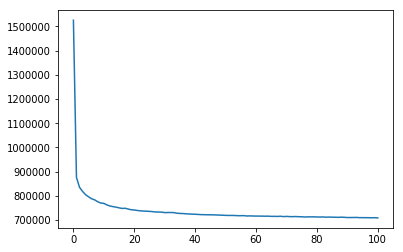

In [14]:
plt.plot(loss_list)

# Testing

We will generate latent vectors to check the performance of our model. For that, we will randomly sample from a normal distribution. Since there are $K$ dimensions to check from, we will keep $K - 1$ dimensions constant and just change the $K^{th}$ dimension.

In this problem, we have taken $K = 3$ so we will change 1st, 2nd and then the 3rd dimension which will finally give us 3 latent vetors to test the performance.

In [0]:
def generate_code_vectors(K , size):
  random_samples = np.random.normal(size=[1,K])

  random_samples = np.repeat(random_samples, size ,axis=0)
  
  return random_samples
  
def change_column(x , column_num):
  x_copy = x.copy()
  
  n_rows = x.shape[0]
  random_column = np.random.normal(size = [n_rows , 1])
  
  x_copy[: , column_num] = random_column[: , 0]
  
  return x_copy

In [0]:
first_column_change = generate_code_vectors(3 , 300)
first_column_change = change_column(first_column_change , 0)

second_column_change = generate_code_vectors(3 , 300)
second_column_change = change_column(second_column_change , 1)

third_column_change = generate_code_vectors(3 , 300)
third_column_change = change_column(third_column_change , 2)

## Checking model performance 

Performance was checked on :


1.   Train data 
2.   Latent Vectors
3.   Test data




In [0]:
def print_digits(inp_data, suptitle , image_indices , grid_row , grid_col):
    
    fig , ax = plt.subplots(grid_row , grid_col, sharex=True, sharey=True, figsize=(grid_row,grid_col))
    
    for ind1 in range(grid_row):
        for ind2 in range(grid_col):
            index = image_indices[ind1 * grid_row + ind2]
            digit = inp_data[index]
            
            ax[ind1][ind2].imshow(digit , cmap = 'gray')
            ax[ind1][ind2].axis('off')
    
    fig.subplots_adjust(hspace=.1)
    fig.suptitle(suptitle)
    plt.show()


### Defining grid parameters

Randomly selecting indices and then extracting images at that indices to check the model performance

In [0]:
grid_row = 5
grid_col = 5
max_images = 300
image_indices = random.sample(range(max_images) , k=grid_row * grid_col)
image_indices.sort()

### Checking performance on Training data

In [0]:
feed_dict = {X : train_data[0:300]}
regen_train = regenerated_img.eval(feed_dict=feed_dict)

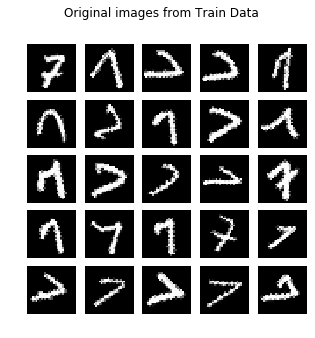

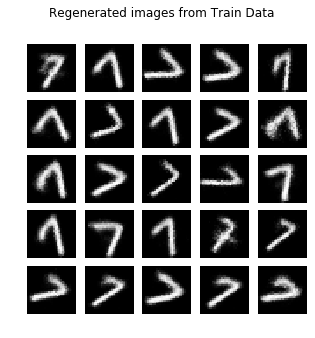

In [20]:
print_digits(train_data, 'Original images from Train Data' , image_indices , 5 , 5)
print_digits(regen_train , 'Regenerated images from Train Data' , image_indices , 5 , 5)

### Checking performance on Latent Vectors

In [0]:
regen_latent_1 = regenerated_img.eval(feed_dict={latent_vector: first_column_change})
regen_latent_2 = regenerated_img.eval(feed_dict={latent_vector: second_column_change})
regen_latent_3 = regenerated_img.eval(feed_dict={latent_vector: third_column_change})

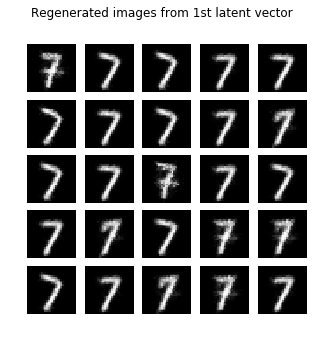

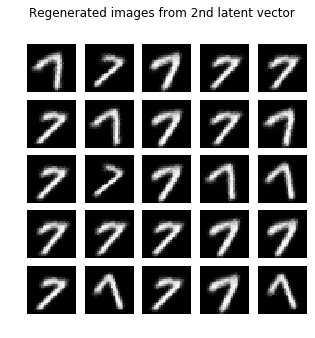

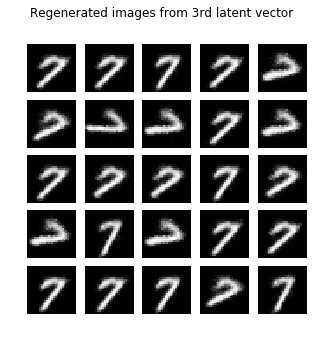

In [33]:
print_digits(regen_latent_1 , 'Regenerated images from 1st latent vector' , image_indices , 5 , 5)
print_digits(regen_latent_2 , 'Regenerated images from 2nd latent vector' , image_indices , 5 , 5)
print_digits(regen_latent_3 , 'Regenerated images from 3rd latent vector' , image_indices , 5 , 5)

### Checking performance on Testing Data

In [0]:
regen_test = regenerated_img.eval(feed_dict={X : test_data})

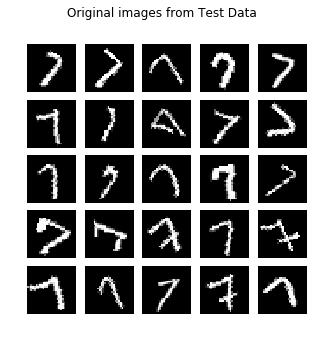

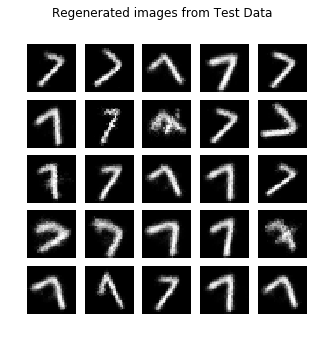

In [24]:
print_digits(test_data , 'Original images from Test Data' , image_indices , 5 , 5)
print_digits(regen_test , 'Regenerated images from Test Data' , image_indices , 5 , 5)